In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda'

In [3]:
for x, y in train_loader:
    break
print(x.shape, y.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [4]:
class RBM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, k, device="cpu"):
        super().__init__()
        self.device = device
        self.w = nn.Parameter(torch.randn(hidden_layer_size, input_size)*1e-2)
        self.b = nn.Parameter(torch.zeros(hidden_layer_size))
        
        self.c = nn.Parameter(torch.zeros(input_size))
        self.var = nn.Parameter(torch.randn(input_size))
        self.k = k
    
    def get_var(self):
        return self.var.clip(min=1e-8)
    
    def p_hv(self, v):
        var = self.get_var()
        return torch.sigmoid((v/var).matmul(self.w.T) + self.b)
    
    def p_vh(self, h):
        return h.matmul(self.w) + self.c
    
    def sample_vh(self, h_prob):
        r = torch.randn(h_prob.size()).to(self.device)

        return (h_prob + r)
    
    def free_energy(self, v):
        var = self.get_var()
        x = (v - self.c)/var
        
        eng = 0.5 * (x**2).mean() - F.softplus((v/(var**2)).matmul(self.w.T) + self.b).mean() 
        return eng
    
    def forward(self, x):
        """Generates x_negative using MCMC Gibbs sampling starting from x."""
        
        x_negative = x
        for _ in range(self.k):
            
            ## Step 1: Sample h from previous iteration.
            # Get the conditional prob h|x
            phx_k = self.p_hv(x_negative) 
            # Sample from h|x
            h_negative = phx_k.bernoulli()
            
            ## Step 2: Sample x using h from step 1.
            # Get the conditional proba x|h
            pxh_k = self.p_vh(h_negative)
            # Sample from x|h
            x_negative = self.sample_vh(pxh_k)

        return x_negative, pxh_k
        

In [5]:
def train(models, device, train_loader, optimizers, epoch):
    for model in models:
        model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # torchvision provides us with normalized data, s.t. input is in [0,1]
        data = data.view(data.size(0),-1) # flatten the array: Converts n_batchx1x28x28 to n_batchx784
        data = data.to(device)
        for model, optimizer in zip(models, optimizers):
            optimizer.zero_grad()

            x_tilde, _ = model(data)
            x_tilde = x_tilde.detach()

            loss = model.free_energy(data) - model.free_energy(x_tilde)
            loss.backward()
            optimizer.step()

def test(models, device, test_loader, epoch):
    for model in models:
        model.eval()
    test_loss = [0]*len(models)
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1) 
            data = data.to(device)
            for i, model in enumerate(models):
                xh_k,_ = model(data)
                loss = F.mse_loss(xh_k, data)
                test_loss[i] += loss.item() # sum up batch loss
    
    print(f"Test {epoch}")
    for tl, h in zip(test_loss, [10,50,100,250]):
        tl = (tl*batch_size)/len(test_loader.dataset)
        print(f'Hidden parameters: {h}, Loss:{tl}')
    print("")

In [6]:
seed = 1
num_epochs = 25
lr = 0.001
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [7]:
rbm10 = RBM(input_size=28*28, hidden_layer_size=10, k=10, device=device).to(device)
rbm50 = RBM(input_size=28*28, hidden_layer_size=50, k=10, device=device).to(device)
rbm100 = RBM(input_size=28*28, hidden_layer_size=100, k=10, device=device).to(device)
rbm250 = RBM(input_size=28*28, hidden_layer_size=250, k=10, device=device).to(device)

rbms = [rbm10, rbm50, rbm100, rbm250]

In [8]:
optimizer10 = optim.Adam(rbm10.parameters(),lr=lr)
optimizer50 = optim.Adam(rbm50.parameters(),lr=lr)
optimizer100 = optim.Adam(rbm100.parameters(),lr=lr)
optimizer250 = optim.Adam(rbm250.parameters(),lr=lr)

optimizers = [optimizer10, optimizer50, optimizer100, optimizer250]

In [9]:
for epoch in tqdm(range(1, num_epochs + 1)):
    train(rbms, device, train_loader, optimizers, epoch)
test(rbms, device, test_loader, epoch)
    
    # print('Optimizer Learning rate: {0:.4f}\n'.format(optimizer.param_groups[0]['lr']))

100%|███████████████████████████████████████████| 25/25 [04:07<00:00,  9.92s/it]


Test 25
Hidden parameters: 10, Loss:1.0989895156860352
Hidden parameters: 50, Loss:1.0812619766235352
Hidden parameters: 100, Loss:1.0823668411254883
Hidden parameters: 250, Loss:1.0846960327148438



In [10]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_13203/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


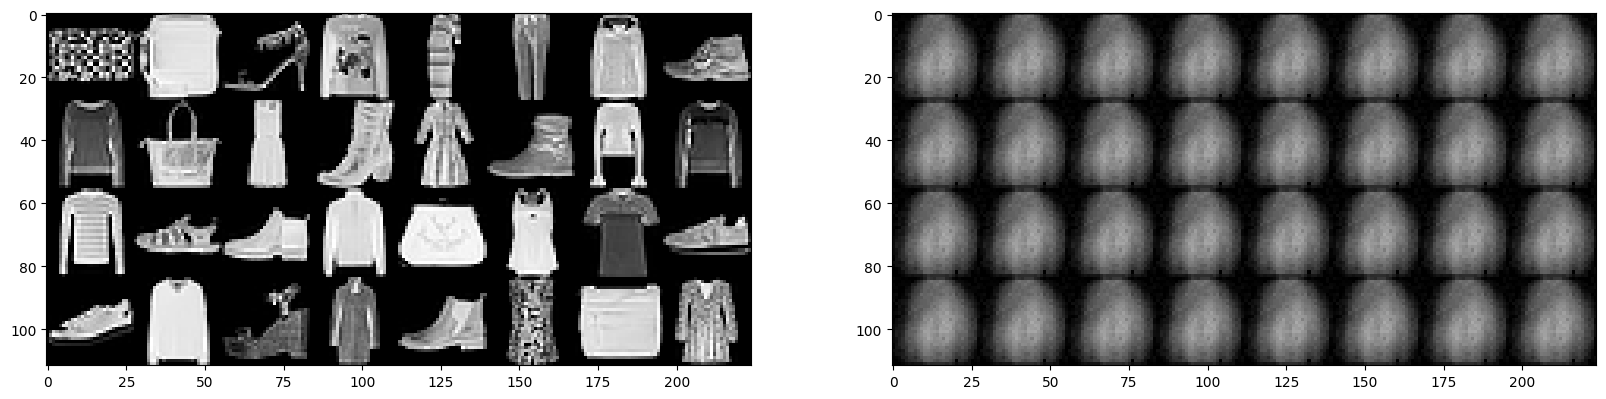

In [11]:
data,_ = next(iter(train_loader))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1)
bdata = data.to(device)
vh_k, pvh_k = rbm10(bdata)
vh_k, pvh_k = vh_k.detach(), pvh_k.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(pvh_k.reshape(data_size), padding=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_13203/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


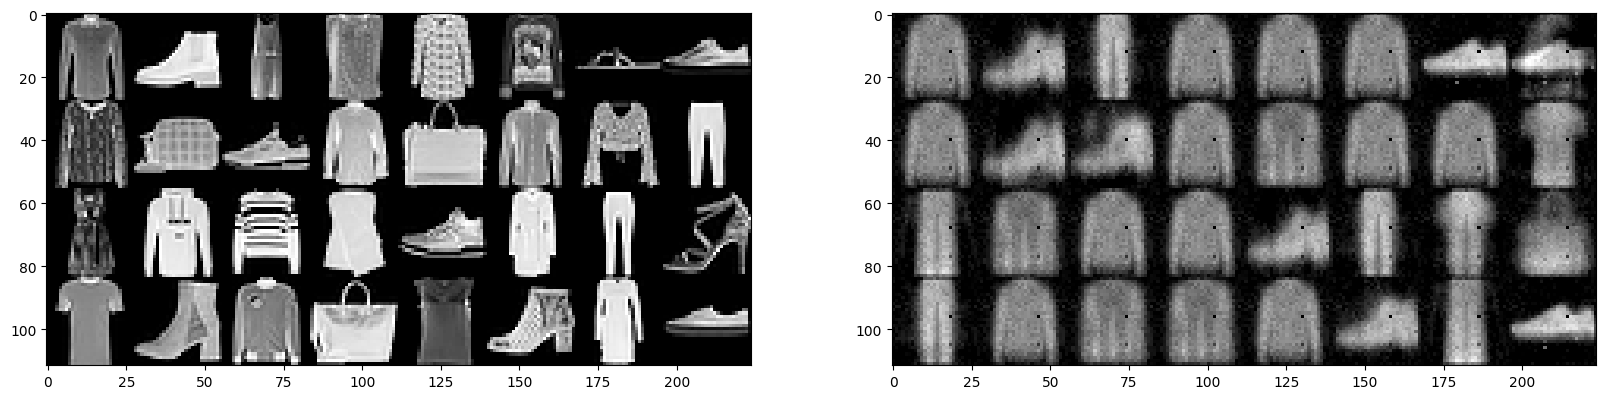

In [12]:
data,_ = next(iter(train_loader))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1)
bdata = data.to(device)
vh_k, pvh_k = rbm50(bdata)
vh_k, pvh_k = vh_k.detach(), pvh_k.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(pvh_k.reshape(data_size), padding=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_13203/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


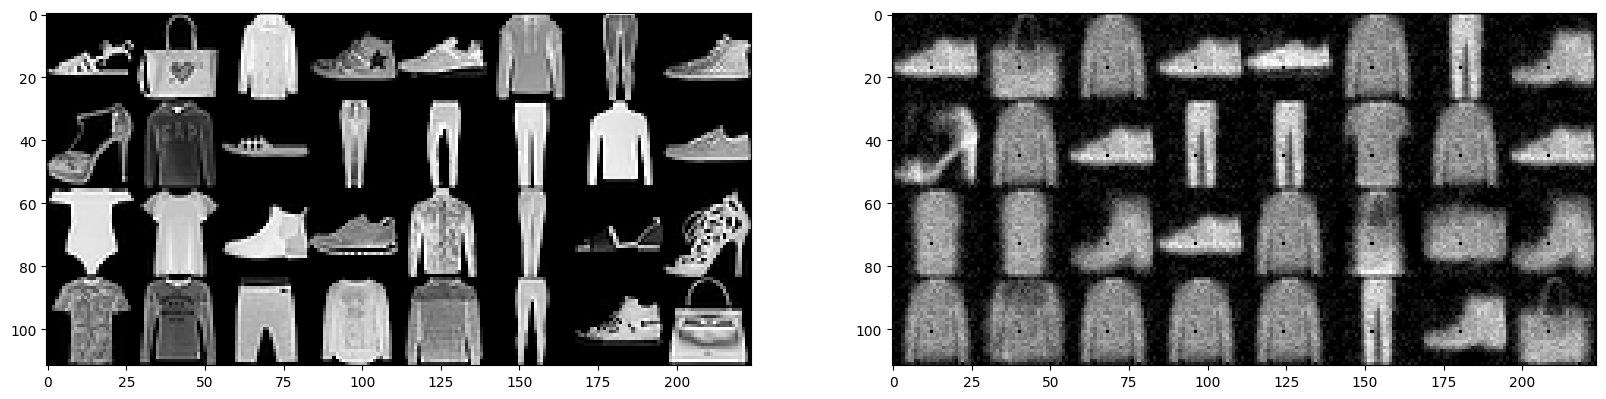

In [13]:
data,_ = next(iter(train_loader))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1)
bdata = data.to(device)
vh_k, pvh_k = rbm100(bdata)
vh_k, pvh_k = vh_k.detach(), pvh_k.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(pvh_k.reshape(data_size), padding=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_13203/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


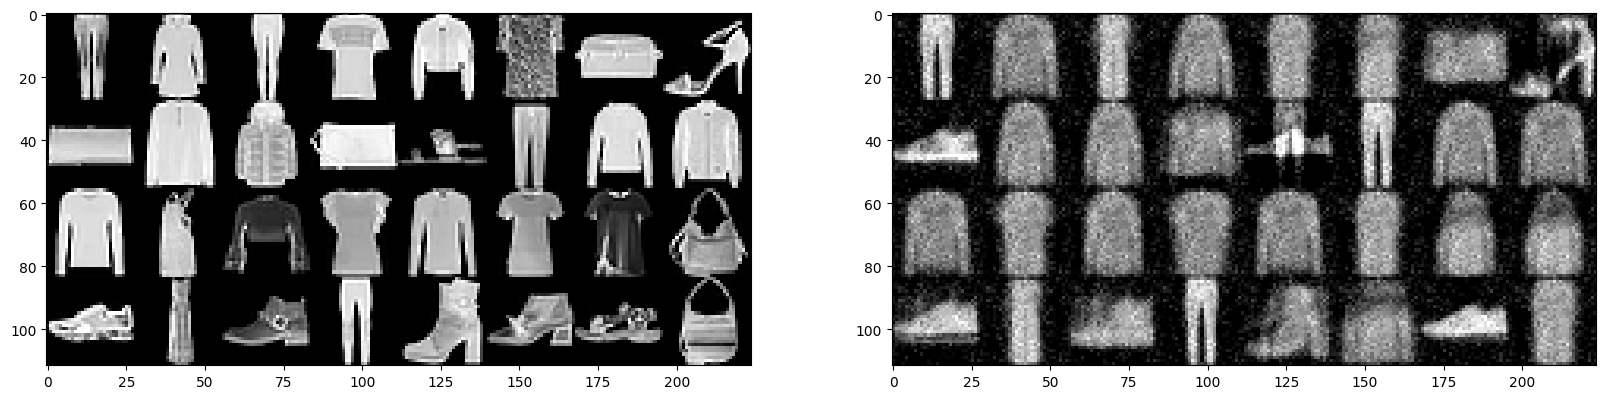

In [14]:
data,_ = next(iter(train_loader))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1)
bdata = data.to(device)
vh_k, pvh_k = rbm250(bdata)
vh_k, pvh_k = vh_k.detach(), pvh_k.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(pvh_k.reshape(data_size), padding=0))